Parser took: 1342 ms.
Parser took: 1324 ms.
Parser took: 1362 ms.


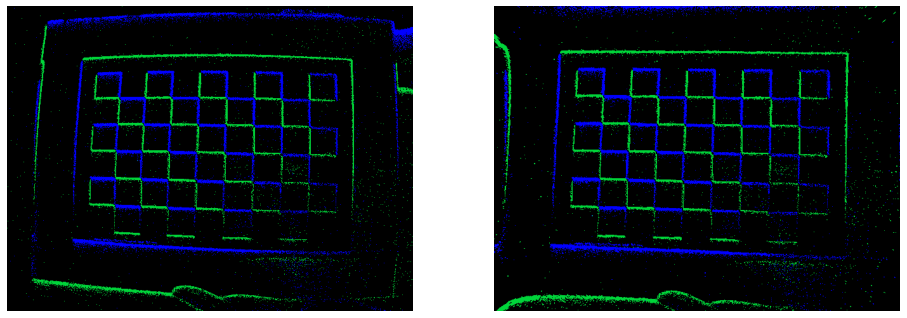

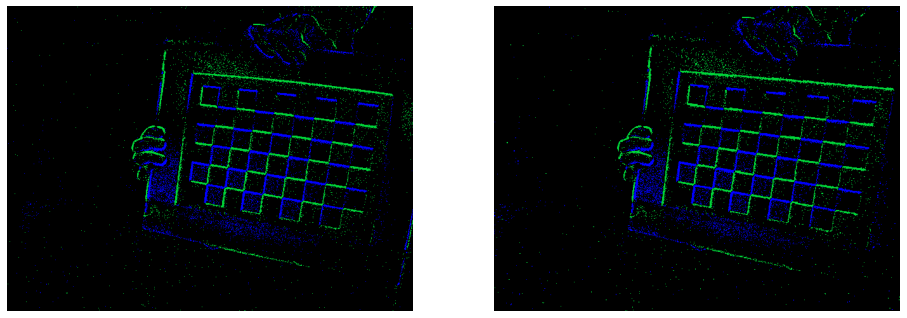

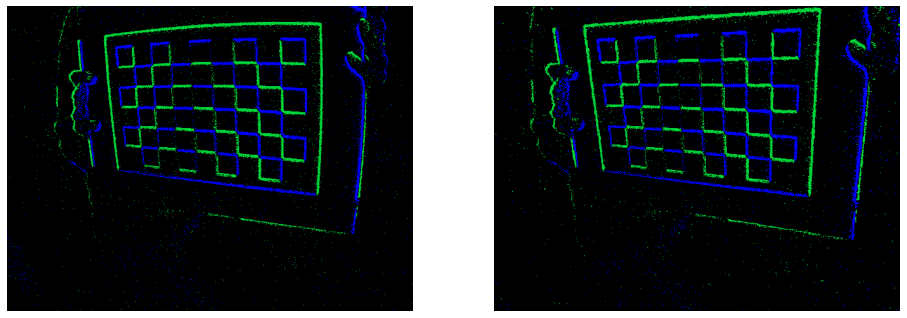

In [1]:

%matplotlib inline

import xml.etree.ElementTree as ET
import re
import time
import numpy as np
import cv2 as cv
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


'''
This function returns all distortions parameters in independent variables
Parameters are extracted from *.xml
'''
def get_params(camera_id):
    
    # 
    # Reading parameters from *.xml
    #

    tree = ET.parse("calibration/parameters/cam" + str(camera_id) + ".xml")
    root = tree.getroot()

    w = int(root[0][2].text) # number of columns in camera sensor
    h = int(root[0][3].text) # number of rows in camera sensor

    # Regular expression to get values out of *.xml
    rescinot = re.compile('[-+]?[\d]+\.?[\d]*[Ee](?:[-+]?[\d]+)?|[\d]')

    # Get Camera Matrix 
    cam_m = np.array(re.findall(rescinot, root[0][0][3].text))  
    cam_m = cam_m.astype(np.float64).reshape((3,3))  
    
    # Distortion Center
    c_x = cam_m[0,2]
    c_y = cam_m[1,2]
    
    # Focal Lengh (in pixels)
    f_x = cam_m[0,0]
    f_y = cam_m[1,1]

    # Get Distortion Coefficients
    d_coeff = np.array(re.findall(rescinot, root[0][1][3].text))
    d_coeff = d_coeff.astype(np.float64)
    
    # Radial Distortion Coefficients
    k_1 = d_coeff[0]
    k_2 = d_coeff[1]
    k_3 = d_coeff[4]
    
    # Tangential Distortion Coefficients
    p_1 = d_coeff[2]
    p_2 = d_coeff[3]
    
    return w, h, c_x, c_y, f_x, f_y, k_1, k_2, k_3, p_1, p_2


'''
This function undistorts a distorted image
'''
def undistort_with_eq_and_show(camera_id):

    # Load parameters
    w, h, c_x, c_y, f_x, f_y, k_1, k_2, k_3, p_1, p_2 = get_params(camera_id)

    # Loading image
    img = cv.imread("images/distorted_" + str(camera_id) + ".png")

    # Undistorting stuff ...    
    dst = np.zeros(img.shape, dtype=int)
    
    for i in range(w): #640
        for j in range(h): #480            
            
            # To relative coordinates
            x = (i-c_x)/f_x           
            y = (j-c_y)/f_y
            r_2 = x*x + y*y
            
            # Radial Distortion
            x_d = x*(1 + k_1 * r_2 + k_2 * r_2 * r_2 + k_3 * r_2 * r_2 * r_2)
            y_d = y*(1 + k_1 * r_2 + k_2 * r_2 * r_2 + k_3 * r_2 * r_2 * r_2)
            
            # Tangential Distortion
            x_d = x_d + (2 * p_1 * x * y + p_2 * (r_2 + 2 * x * x))
            y_d = y_d + (p_1 * (r_2 + 2 * y * y) + 2 * p_2 * x * y)
            
            # To absolute coordinate
            x_d = x_d*f_x + c_x
            y_d = y_d*f_y + c_y
            
            if ((x_d>=0) and (x_d<w)) and ((y_d>=0) and (y_d<h)):
                dst[j, i, :] = img[int(y_d), int(x_d), :]
    
            else:
                print("wtf!")

    #
    # Plotting Stuff
    #
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].imshow(img)
    axs[1].imshow(dst)
    

    

if __name__ == "__main__":
    
    for i in [1,2,3]:
        camera_id = i
        
        start = time.time()
        undistort_with_eq_and_show(camera_id)
        stop = time.time()

        elapsed = stop - start
        print("Parser took: " + str(int(1000*elapsed)) + " ms.")